<a href="https://colab.research.google.com/github/davideliseo/ia-icci-g2/blob/main/lab-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 1 - Reconocimiento de imágenes

- **Grupo**: 2
- **Integrantes**: Lukas Poffal Munita y David Uribe Fuentes

## 1. Modelo

### 1.1. Configuración

In [1]:
import numpy as np                              # NumPy es una librería para computación numérica en Python, que proporciona soporte para arreglos, matrices y diversas operaciones matemáticas.
import tensorflow as tf                         # Esta línea importa la librería Keras desde TensorFlow. Keras es una API de redes neuronales de alto nivel escrita en Python, que se ejecuta sobre TensorFlow. Keras se utiliza para construir y entrenar modelos de redes neuronales.                     
from tensorflow.keras import layers, Model      # Keras proporciona diversas capas predefinidas, como capas densas, convolucionales, recurrentes, de agrupamiento, de normalización, entre otras. Al importar el módulo de capas, se pueden utilizar estas capas para construir modelos de redes neuronales en TensorFlow.

In [2]:
# Monta la unidad de Google Drive en Google Colab y establecer la ubicación de la carpeta que se utilizará para trabajar en el notebook.
from google.colab import drive                            
drive.mount("/content/drive", force_remount=True)

PATH = "/content/drive/Shareddrives/G2 - IA/Lab 1"
WEIGHTS_PATH = f"{PATH}/out/checkpoint/weights"
LOG_PATH = f"{PATH}/out/log.csv"

Mounted at /content/drive


### 1.2. Carga de datos

In [3]:
# Modelo / parámetros de los datos
NUM_CLASSES = 10 # Cantidad de dígitos distinguibles
IMAGE_SHAPE = (28, 28)
INPUT_SHAPE = (*IMAGE_SHAPE, 1)

# Carga los
def load_data():
  return tf.keras.datasets.mnist.load_data()

### 1.3. Preprocesamiento de datos

In [4]:
def preprocess_data(data):
  # Divide los datos entre el 'train' y los conjuntos de prueba 'test'
  (x_train, y_train), (x_test, y_test) = data


  # Escala imágenes al rango [0, 1]
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Asegura de que las imágenes tengan forma (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # Convierte los clase vectores en matrices de clase binaria
  y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
  y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)
  return (x_train, y_train), (x_test, y_test)

### 1.4. Construcción

In [5]:
def assemble_model():
  # Define un modelo de red neuronal convolucional (CNN) utilizando la API de Keras de TensorFlow
  model = tf.keras.Sequential([
      tf.keras.Input(shape=INPUT_SHAPE),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(NUM_CLASSES, activation="softmax"),
  ])

  # Configura el modelo para su entrenamiento
  model.compile(
      loss="categorical_crossentropy", 
      optimizer="adam", 
      metrics=["accuracy"]
  )

  return model

### 1.5. Entrenamiento


In [6]:
def train_model(model: Model, x_train, y_train) -> Model:
  # Se determina el tamaño del lote utilizado para entrenar el modelo
  batch_size = 128

  # Se determina el número de épocas, o iteraciones completas a través de todo el conjunto de datos de entrenamiento, que se utilizarán para entrenar el modelo
  epochs = 15

  # Define un objeto de registro que registra la información de la precisión y la pérdida del modelo durante el entrenamiento
  logger = tf.keras.callbacks.CSVLogger(LOG_PATH, append=False)

  # Se crea un objeto checkpointing que guarda los pesos del modelo después de cada época en la ubicación especificada en 'filepath'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath=WEIGHTS_PATH,
      save_weights_only=True,
      save_best_only=True,
      save_freq="epoch",
      monitor="val_accuracy",
      mode="auto",
      verbose=1,
  )

  # Entrena el modelo utilizando los datos de entrenamiento (x_train e y_train)
  model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.1,
      callbacks=[logger, checkpoint]
  )

  return model

### 1.6. Carga de pesos exportados

In [7]:
def load_model(model: Model) -> Model:
    model.load_weights(WEIGHTS_PATH)
    return model

### 1.7. Evaluación y análisis

In [33]:
from PIL import Image
import io

def normalize_img(img: bytes):
  img = Image.open(io.BytesIO(img))
  img = img.convert("L")
  img = img.resize(IMAGE_SHAPE)
  img_array = np.asarray(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  return img_array

def classify_digit(model: Model, img: bytes):
  img_array = normalize_img(img)
  predictions = model.predict(img_array, verbose=0)
  max_value = np.max(predictions)
  max_index = np.argmax(predictions)
  return max_index, max_value

In [9]:
from enum import unique, Enum
import os

@unique
class ModelMode(str, Enum):
    AUTO = "auto"
    LOAD = "load"
    TRAIN = "train"

model = assemble_model()
(x_train, y_train), (x_test, y_test) = preprocess_data(load_data())

mode = ModelMode.LOAD
if mode == ModelMode.AUTO:
    if os.path.isfile(WEIGHTS_PATH):
        mode = ModelMode.LOAD 
    else: 
        mode = ModelMode.TRAIN

if mode == ModelMode.LOAD:
    model = load_model(model)

elif mode == ModelMode.TRAIN:
    model = train_model(model, x_train, y_train)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
with open(f"{PATH}/test.png", "rb") as f:
  print(classify_digit(model, f.read()))

PNG
1/1 [==============================] - 0s 301ms/step
(7, 0.99999833)


### 1.8. Validación

Test loss: 0.025668218731880188
Test accuracy: 0.9916999936103821
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                        

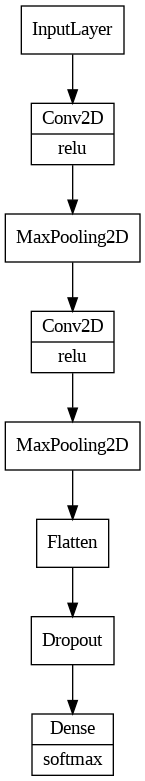

In [11]:
# Se valida el modelo utilizando el conjunto de datos de prueba 'test'
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Imprime un resumen del modelo, que muestra la arquitectura de la red, el 
# número de parámetros entrenables y la forma de los datos en cada capa
print(model.summary())

from keras.utils import plot_model
plot_model(model, show_layer_names=False, show_layer_activations=True)

## 2. Aplicación

## Frontend

In [53]:
from google.colab import output
import IPython as ipy
import base64
import traceback

def classify_digit_callback(img):
  try:
    _, img = img.split(",", 1) # Elimina el prefijo "data:(...)"
    decoded = base64.b64decode(img)

    digit, score = classify_digit(model, decoded)
    return ipy.display.JSON(dict(digit=digit, score=score))
  except Exception:
    traceback.print_exc()

output.register_callback("notebook.classify-digit", classify_digit_callback)

In [55]:
ipy.display.HTML(f"{PATH}/index.html")